In [18]:
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import *

In [19]:
os.listdir('Data/nyt-comments/')

['ArticlesFeb2017.csv',
 'CommentsFeb2018.csv',
 'ArticlesApril2017.csv',
 'CommentsApril2018.csv',
 'ArticlesMarch2018.csv',
 'CommentsMarch2017.csv',
 'ArticlesMay2017.csv',
 'ArticlesJan2017.csv',
 'CommentsJan2018.csv',
 'CommentsMarch2018.csv',
 'ArticlesJan2018.csv',
 'CommentsMay2017.csv',
 'CommentsJan2017.csv',
 'ArticlesMarch2017.csv',
 'CommentsApril2017.csv',
 'ArticlesFeb2018.csv',
 'CommentsFeb2017.csv',
 'ArticlesApril2018.csv']

In [20]:
DATA_DIR = 'Data/nyt-comments/'

## Composing data set:

In [21]:
headlines = []
for filename in os.listdir(DATA_DIR):
    if 'Articles' in filename:
        curr = pd.read_csv(os.path.join(DATA_DIR, filename))
        headlines += list(curr['headline'].values)
headlines = [hl for hl in headlines if hl != 'Unknown']
print(len(headlines))

8603


In [22]:
def preprocess(x):
    res = "".join(ch for ch in x if ch not in string.punctuation).lower()
    res = res.encode("utf8").decode("ascii",'ignore')
    return res

In [23]:
headlines = [preprocess(x) for x in headlines]

## Importing pre-trained GLOVE embedding:

In [24]:
EMB_FILE = 'Data/glove/glove.6B.50d.txt'

In [25]:
class Tokenizer:
    
    def __init__(self, corpus):
        self.unique_tokens = set(['PAD', '<\s>'])
        self.new_corpus = []
        print('Getting unique tokens')
        for i, sentence in tqdm_notebook(enumerate(corpus)):
            [self.unique_tokens.add(word) for word in sentence.split()]
            self.new_corpus.append(sentence + ' <\s>')
            
    def filter_embeddings(self, emb_file):
        self.words = ['PAD', '<\s>']
        self.vecs = []
        print('Filtering embeddings')
        with open(emb_file) as fn:
            for line in tqdm_notebook(fn):
                line = line.strip().split(' ')
                if line[0] in self.unique_tokens:
                    self.words.append(line[0])
                    self.vecs.append(np.array([float(num) for num in line[1:]]))
        self.vecs.insert(0, np.random.randn(*self.vecs[0].shape))
        self.vecs.insert(0, np.random.randn(*self.vecs[0].shape))
        self.index_dic = {word:i for i, word in enumerate(self.words)}
        
    def tokenize(self):
        self.tokenized = []
        for sentence in self.new_corpus:
            t_seq = []
            for word in sentence.split(' '):
                try:
                    token = self.index_dic[word]
                    t_seq.append(token)
                except:
                    new_index = len(self.index_dic)
                    self.index_dic[word] = new_index
                    t_seq.append(new_index)
                    self.vecs.append(np.random.randn(*self.vecs[0].shape))
                    assert(len(self.index_dic) == len(self.vecs))
            self.tokenized.append(t_seq)
        self.inv_dic = {v:k for k, v in self.index_dic.items()}
        return self.tokenized, np.vstack(self.vecs).astype('float32')

In [26]:
tokenizer = Tokenizer(headlines)

Getting unique tokens


In [27]:
tokenizer.filter_embeddings(EMB_FILE)

Filtering embeddings


In [28]:
tokenized_corpus, vecs = tokenizer.tokenize()

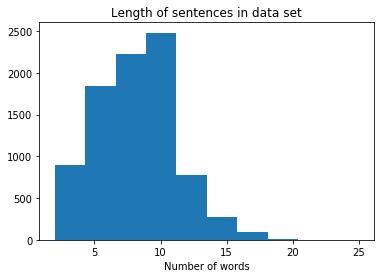

In [29]:
plt.hist([len(x) for x in tokenizer.tokenized])
plt.title('Length of sentences in data set')
_ = plt.xlabel('Number of words')

In [35]:
class SequenceDataset(Dataset):
    
    def __init__(self, tokenized):
        self.tokenized = [torch.tensor(seq) for seq in tokenized]
    
    def __getitem__(self, idx):
        if type(idx) == slice:
            #Dataloader doesn't use slices 
            #Thus this piece of code isn't used
            #Left if one would lije to modify overall pipeline and work with slices
            x = self.tokenized[idx]
            y = [seq[1:] for seq in x]
            x = [seq[:-1] for seq in x]
            lengths = [len(seq) for seq in x]
            x = pad_sequence(x) #from torch.nn.utils.rnn
            y = pad_sequence(y)
            return x, y, lengths
        elif type(idx) == int:
            x = self.tokenized[idx][:-1]
            y = self.tokenized[idx][1:]
            length = len(x)
            return x, y, length
        else:
            raise TypeError('Incorrect index type')
            
    def __len__(self):
        return len(self.tokenized)

def custom_collate(data):
    data = sorted(data, key=lambda x: x[2], reverse=True) #Consider whether you need enforce_sorted=True
    x, y, lengths = zip(*data)
    x = pad_sequence(x)
    y = pad_sequence(y)
    return x, y, lengths

class LanguageModel(nn.Module):
    
    def __init__(self, embeddings, h_size, train_emb=False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        self.vocab_size = embeddings.shape[0]
        self.train_emb = train_emb
        if train_emb:
            self.embedding.weight.requires_grad = True # if we want to continue training
            parameters = self.parameters()
        else:
            parameters = filter(lambda x: x.requires_grad, self.parameters())
            
        self.h_size = h_size
        self.lstm = nn.LSTM(embeddings.shape[1], h_size)
        self.hidden = None
        self.fc = nn.Linear(h_size, self.vocab_size)
        self.lsm = nn.LogSoftmax(dim=-1)
        #self.asm = nn.AdaptiveLogSoftmaxWithLoss() #Consider!

        self.opt = torch.optim.Adam(parameters)
        self.loss_fn = torch.nn.NLLLoss(reduction='mean')
        
    def init_hidden(self, batch_size):
        self.hidden = [torch.randn((1, batch_size, self.h_size)).type('torch.FloatTensor') for _ in range(2)]
        
    def forward(self, x, lengths):
        x = self.embedding(x)
        x = pack_padded_sequence(x, lengths)
        x, self.hidden = self.lstm(x, self.hidden)
        x, pl = pad_packed_sequence(x)
        x = self.lsm(self.fc(x))
        return x, pl
    
    def fit(self, dataset, n_epochs, batch_size):
        dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
        for i in tqdm_notebook(range(n_epochs)):
            r_loss = 0
            j = 0
            for x_batch, y_batch, lengths in dl:
                #print(j)
                bs = x_batch.shape[1]
                self.init_hidden(bs)
                #out, _ = self.forward(x_batch, lengths)
                try:
                    out, _ = self.forward(x_batch, lengths)
                except:
                    return x_batch, y_batch, lengths
                self.opt.zero_grad()
                try:
                    loss_val = self.loss_fn(out.view(-1, self.vocab_size), y_batch.flatten())
                except:
                    print(i, j)
                    return x_batch, y_batch, lengths, out
                loss_val.backward()
                self.opt.step()
                
                r_loss += loss_val.item()
                j += 1
            print(f'Epoch {i}, loss: {round(r_loss/j, 5)}')
            
    def generate(self, start_word, tokenizer, sample=False):
        self.eval()
        with torch.no_grad():
            curr_index = tokenizer.index_dic[start_word]
            self.init_hidden(1)
            sequence = [curr_index]
            while curr_index != 1: #1 is EOS index
                curr_tensor = torch.tensor([curr_index]).view(1, 1)
                out, _ = self(curr_tensor, [1])
                if sample:
                    curr_index = np.random.choice(out.shape[-1], p=out.flatten().exp().numpy())
                else:
                    curr_index = torch.argmax(out).item()
                sequence.append(curr_index)
            sequence = ' '.join([tokenizer.inv_dic[idx] for idx in sequence])
        return sequence

In [36]:
HIDDEN_SIZE = 32
BATCH_SIZE = 16
N_EPOCHS = 50

In [37]:
dataset = SequenceDataset(tokenized_corpus)

In [38]:
model = LanguageModel(vecs, HIDDEN_SIZE)

In [39]:
res = model.fit(dataset, N_EPOCHS, BATCH_SIZE)

Epoch 0, loss: 8.08627
Epoch 1, loss: 7.44987
Epoch 2, loss: 7.13129
Epoch 3, loss: 6.81872
Epoch 4, loss: 6.5097
Epoch 5, loss: 6.1968
Epoch 6, loss: 5.88512
Epoch 7, loss: 5.57657
Epoch 8, loss: 5.27119
Epoch 9, loss: 4.9825
Epoch 10, loss: 4.69003
Epoch 11, loss: 4.41025
Epoch 12, loss: 4.15464
Epoch 13, loss: 3.93017
Epoch 14, loss: 3.71844
Epoch 15, loss: 3.56279
Epoch 16, loss: 3.44058
Epoch 17, loss: 3.34048
Epoch 18, loss: 3.23965
Epoch 19, loss: 3.1692
Epoch 20, loss: 3.11802
Epoch 21, loss: 3.08116
Epoch 22, loss: 3.04657
Epoch 23, loss: 2.99471
Epoch 24, loss: 2.98284
Epoch 25, loss: 2.94257
Epoch 26, loss: 2.92351
Epoch 27, loss: 2.88537
Epoch 28, loss: 2.86145
Epoch 29, loss: 2.85256
Epoch 30, loss: 2.82741
Epoch 31, loss: 2.79446
Epoch 32, loss: 2.79359
Epoch 33, loss: 2.77608
Epoch 34, loss: 2.75567
Epoch 35, loss: 2.71963
Epoch 36, loss: 2.71617
Epoch 37, loss: 2.70122
Epoch 38, loss: 2.69524
Epoch 39, loss: 2.67492
Epoch 40, loss: 2.67589
Epoch 41, loss: 2.6662
Epoch 4

In [62]:
for i in range(10):
    print(model.generate('world', tokenizer, sample=True))

world endings gently <\s>
world rise flynns bookworms eating <\s>
world interests spending for the focus <\s>
world at veterans affairs up trying shutdown gentrification <\s>
world am preparing in school shooting vs meets railroads <\s>
world cup politics <\s>
world to transgender wages <\s>
world men held jail <\s>
world invites is wrong are again <\s>
world a happy latest spectators maligning full neighbors all of flood widens problems <\s>


In [65]:
for i in range(10):
    print(model.generate('world', tokenizer, sample=False))

world of the world <\s>
world of the world <\s>
world to the world <\s>
world <\s>
world of the world <\s>
world fiddler <\s>
world of the world <\s>
world of the world <\s>
world of the world <\s>
world bridges <\s>


In [69]:
for i in range(10):
    print(model.generate('new', tokenizer, sample=True))

new york today for approach <\s>
new york today to china with get labor students 26 <\s>
new first upper east starbucks with caffeine athletes <\s>
new york today documenting tips for blood was police its a personal touch <\s>
new  moments <\s>
new york today google feel theyre checkpoints easy presidential muscle inquiry <\s>
new york today taxpayer <\s>
new york our coming with all some kids her 8 my husbands <\s>
new challenges query hope to end at moods <\s>
new york today lesson a fun <\s>


In [70]:
for i in range(10):
    print(model.generate('new', tokenizer, sample=False))

new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
new york today a new of a liquid <\s>
